In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


In [2]:
# Carregar os dados
url = "https://raw.githubusercontent.com/cleodecker/tcc/main/df_all.csv"
cache_file = "df_all.csv"

if not os.path.exists(cache_file):
    df = pd.read_csv(url)
    df.to_csv(cache_file, index=False)
    print("Dataset baixado do GitHub e salvo em cache")
else:
    df = pd.read_csv(cache_file)
    print("Dataset carregado do cache local")
print(f'Dataset carregado: {df.shape}')
print(f'Colunas: {list(df.columns)}')
print(f'\nPrimeiras linhas:')
print(df.head())

Dataset baixado do GitHub e salvo em cache
Dataset carregado: (7744, 23)
Colunas: ['Country', 'Year', '0', '1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', 'Gender']

Primeiras linhas:
   Country  Year        0        1        5       10       15       20  \
0        0  1950  0.02836  0.00182  0.00089  0.00076  0.00138  0.00206   
1        0  1951  0.02832  0.00189  0.00081  0.00077  0.00169  0.00223   
2        0  1952  0.02791  0.00171  0.00069  0.00064  0.00156  0.00203   
3        0  1953  0.02632  0.00170  0.00076  0.00069  0.00153  0.00189   
4        0  1954  0.02558  0.00176  0.00064  0.00062  0.00146  0.00183   

        25       30  ...       50       55       60       65       70  \
0  0.00164  0.00188  ...  0.01097  0.01736  0.02767  0.04246  0.06596   
1  0.00183  0.00193  ...  0.01125  0.01843  0.02888  0.04370  0.06585   
2  0.00185  0.00188  ...  0.01124  0.01791  0.02854  0.04394  0.06474   
3  0.00165  0.0

In [3]:
# Função para calcular sMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Função para calcular intervalos de confiança
def calculate_confidence_intervals(predictions, residuals, confidence=0.95):
    """
    Calcula intervalos de confiança baseados nos resíduos do modelo
    """
    alpha = 1 - confidence
    std_residuals = np.std(residuals)
    z_score = 1.96  # Para 95% de confiança

    margin_error = z_score * std_residuals
    lower_bound = predictions - margin_error
    upper_bound = predictions + margin_error

    return lower_bound, upper_bound

In [4]:
# Função de pré-processamento
def preprocess_data(df, country_code=49, sequence_length=10):
    """
    Pré-processa dados para modelo LCCNN com transformação log + normalização
    para ambos os sexos (0 e 1) simultaneamente.

    Retorna:
        dict_processed: Dicionário com estrutura {gender: {age_group: processed_data}}
        dict_scalers: Dicionário com scalers {gender: {age_group: scaler}}
        metadata: Informações adicionais
    """
    # Converter country_code se necessário
    if isinstance(country_code, str):
        country_code = int(country_code)

    # Filtrar dados do país
    country_data = df[df['Country'] == country_code].copy()

    if country_data.empty:
        print(f'AVISO: Nenhum dado encontrado para País={country_code}')
        return None, None, None

    print(f'Dados do país {country_code}: {len(country_data)} registros')

    # Identificar colunas de idade
    exclude_cols = ['Country', 'Year', 'Gender']
    age_columns = sorted([col for col in df.columns if col not in exclude_cols],
                         key=lambda x: int(x))

    # Estruturas para armazenamento
    dict_processed = {0: {}, 1: {}}
    dict_scalers = {0: {}, 1: {}}
    metadata = {
        'years': sorted(country_data['Year'].unique()),
        'age_columns': age_columns
    }

    # Processar cada gênero separadamente
    for gender in [0, 1]:
        print(f'\nProcessando gênero {gender}...')
        gender_data = country_data[country_data['Gender'] == gender].sort_values('Year')

        for age_col in age_columns:
            # Extrair série temporal
            time_series = gender_data[age_col].values.reshape(-1, 1)

            # Aplicar transformação logarítmica
            log_series = np.log1p(time_series)

            # Normalizar
            scaler = MinMaxScaler()
            normalized_data = scaler.fit_transform(log_series)

            # Criar sequências
            X, y = [], []
            sequence_years = []

            for i in range(sequence_length, len(normalized_data)):
                X.append(normalized_data[i-sequence_length:i, 0])
                y.append(normalized_data[i, 0])
                sequence_years.append(gender_data['Year'].iloc[i])

            if len(X) > 0:
                dict_processed[gender][age_col] = {
                    'X': np.array(X),
                    'y': np.array(y),
                    'original_data': time_series.flatten(),
                    'sequence_years': np.array(sequence_years)
                }
                dict_scalers[gender][age_col] = scaler

                # Verificação básica
                n_sequences = len(X)
                min_year = min(sequence_years)
                max_year = max(sequence_years)
                print(f'  Grupo {age_col}: {n_sequences} sequências ({min_year}-{max_year})')

    return dict_processed, dict_scalers, metadata

In [5]:
# Função LCCNN
def create_lccnn_model(sequence_length=10, n_features=1):
    """
    Cria modelo LCCNN (CNN + LSTM) aprimorado com:
    - Camadas convolucionais para extração de características locais
    - Funções de ativação ReLU
    - Regularização L2
    - Batch Normalization
    - Ajuste de hiperparâmetros
    """
    model = Sequential([
        # Bloco Convolucional 1
        Conv1D(filters=64, kernel_size=3, activation='relu',
               input_shape=(sequence_length, n_features),
               padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Bloco Convolucional 2
        Conv1D(filters=128, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),

        # Camadas LSTM
        LSTM(100, return_sequences=True,
             kernel_regularizer=l2(0.001)), # Fix: Removed the misplaced parenthesis here
        BatchNormalization(),
        Dropout(0.3),

        LSTM(50, return_sequences=False,
             kernel_regularizer=l2(0.001)),
        Dropout(0.4),

        # Camadas Densas
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dense(1)  # Camada de saída (sem ativação para regressão)
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='mse',
                  metrics=['mae', 'mse'])

    return model

In [6]:
# Processar dados para o país (ambos os gêneros)
print('=== PROCESSANDO DADOS PARA PAÍS 49 (BRASIL) ===')
processed_data, scalers_dict, metadata = preprocess_data(df, country_code=49, sequence_length=10)

if processed_data is not None:
    # Separar dados por gênero
    data_male = processed_data[0]   # Dados para homens (gender=0)
    scalers_male = scalers_dict[0]

    data_female = processed_data[1] # Dados para mulheres (gender=1)
    scalers_female = scalers_dict[1]

    # Metadados
    age_cols = metadata['age_columns']
    years = metadata['years']

    print(f'\nDados processados:')
    print(f'Grupos etários: {len(age_cols)}')
    print(f'Anos disponíveis: {min(years)} - {max(years)}')
    print(f'  Homens: {len(data_male)} grupos etários com dados')
    print(f'  Mulheres: {len(data_female)} grupos etários com dados')

    # Verificar um grupo específico para homens
    sample_age_group = age_cols[0]
    if sample_age_group in data_male:
        male_sample = data_male[sample_age_group]
        print(f"\nExemplo grupo masculino '{sample_age_group}':")
        print(f"  Sequências X: {male_sample['X'].shape}")
        print(f"  Alvos y: {male_sample['y'].shape}")
        print(f"  Anos das sequências: {male_sample['sequence_years'][:5]}...{male_sample['sequence_years'][-5:]}")

    # Verificar um grupo específico para mulheres
    if sample_age_group in data_female:
        female_sample = data_female[sample_age_group]
        print(f"\nExemplo grupo feminino '{sample_age_group}':")
        print(f"  Sequências X: {female_sample['X'].shape}")
        print(f"  Alvos y: {female_sample['y'].shape}")
        print(f"  Anos das sequências: {female_sample['sequence_years'][:5]}...{female_sample['sequence_years'][-5:]}")
else:
    print('Erro no processamento dos dados')

=== PROCESSANDO DADOS PARA PAÍS 49 (BRASIL) ===
Dados do país 49: 48 registros

Processando gênero 0...
  Grupo 0: 14 sequências (2010-2023)
  Grupo 1: 14 sequências (2010-2023)
  Grupo 5: 14 sequências (2010-2023)
  Grupo 10: 14 sequências (2010-2023)
  Grupo 15: 14 sequências (2010-2023)
  Grupo 20: 14 sequências (2010-2023)
  Grupo 25: 14 sequências (2010-2023)
  Grupo 30: 14 sequências (2010-2023)
  Grupo 35: 14 sequências (2010-2023)
  Grupo 40: 14 sequências (2010-2023)
  Grupo 45: 14 sequências (2010-2023)
  Grupo 50: 14 sequências (2010-2023)
  Grupo 55: 14 sequências (2010-2023)
  Grupo 60: 14 sequências (2010-2023)
  Grupo 65: 14 sequências (2010-2023)
  Grupo 70: 14 sequências (2010-2023)
  Grupo 75: 14 sequências (2010-2023)
  Grupo 80: 14 sequências (2010-2023)
  Grupo 85: 14 sequências (2010-2023)
  Grupo 90: 14 sequências (2010-2023)

Processando gênero 1...
  Grupo 0: 14 sequências (2010-2023)
  Grupo 1: 14 sequências (2010-2023)
  Grupo 5: 14 sequências (2010-2023)
  G

In [7]:
# Função para treinar modelo e fazer previsões com LOG + NORMALIZAÇÃO
def train_and_predict(data_dict, scalers_dict, gender_name, years_available, sequence_length=10):
    """
    Treina modelos para cada grupo etário e faz previsões
    Período de treino: 2000-2014 | Período de teste: 2015-2019
    """
    models = {}
    predictions_dict = {}
    metrics_dict = {}

    print(f'\n=== TREINANDO MODELOS PARA {gender_name.upper()} ===')

    for age_group in data_dict.keys():
        print(f'\nTreinando modelo para grupo etário {age_group}...')

        # Dados de treino
        X = data_dict[age_group]['X']
        y = data_dict[age_group]['y']
        years_for_sequences = data_dict[age_group]['sequence_years']

        # Verificar se temos dados suficientes para os períodos desejados
        available_years = set(years_for_sequences)
        train_years = set(range(2000, 2015))  # 2000-2014
        test_years = set(range(2015, 2020))   # 2015-2019

        if not train_years.intersection(available_years):
            print(f'AVISO: Nenhum ano de treino (2000-2014) disponível para grupo {age_group}')
            continue

        if not test_years.intersection(available_years):
            print(f'AVISO: Nenhum ano de teste (2015-2019) disponível para grupo {age_group}')
            continue

        # Criar máscaras para treino e teste
        train_mask = np.isin(years_for_sequences, list(range(2000, 2015)))
        test_mask = np.isin(years_for_sequences, list(range(2015, 2020)))

        # Aplicar máscaras
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]

        # Verificar se temos dados suficientes após a divisão
        if len(X_train) < 5:
            print(f'Dados de treino insuficientes para grupo etário {age_group} (apenas {len(X_train)} amostras)')
            continue

        if len(X_test) < 1:
            print(f'Dados de teste insuficientes para grupo etário {age_group} (apenas {len(X_test)} amostras)')
            continue

        print(f'Grupo {age_group}: {len(X_train)} amostras de treino, {len(X_test)} amostras de teste')

        # Reshape para LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Criar e treinar modelo com callbacks
        model = create_lccnn_model(sequence_length=X_train.shape[1])

        # Callbacks para melhorar treinamento
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.00001
        )

        try:
            history = model.fit(
                X_train, y_train,
                epochs=200,  # Aumentado devido à complexidade do modelo
                batch_size=16,  # Reduzido para melhor generalização
                validation_data=(X_test, y_test),
                callbacks=[early_stop, reduce_lr],
                verbose=1
            )

            models[age_group] = model

            # Fazer previsões no conjunto de teste
            y_pred = model.predict(X_test, verbose=0)

            # Desnormalizar previsões
            scaler = scalers_dict[age_group]
            y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
            y_pred_denorm = scaler.inverse_transform(y_pred).flatten()

            # Aplicar inversa do LOG (expm1)
            y_test_orig = np.expm1(y_test_denorm)
            y_pred_orig = np.expm1(y_pred_denorm)

            # Calcular métricas
            rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
            mae = mean_absolute_error(y_test_orig, y_pred_orig)
            smape_val = smape(y_test_orig, y_pred_orig)

            metrics_dict[age_group] = {
                'RMSE': rmse,
                'MAE': mae,
                'sMAPE': smape_val,
                'history': history.history  # Salvar histórico para análise
            }

            print(f'Grupo {age_group} - RMSE: {rmse:.6f}, MAE: {mae:.6f}, sMAPE: {smape_val:.2f}%')

            # Fazer previsões para 2020-2070
            last_sequence = data_dict[age_group]['X'][-1].reshape(1, -1, 1)
            future_predictions = []
            future_uncertainty = []  # Para capturar incerteza

            # Calcular resíduos para intervalos de confiança
            residuals = y_test_orig - y_pred_orig

            for year in range(2020, 2071):
                # Gerar 100 previsões com dropout ativo para estimar incerteza
                preds = []
                for _ in range(100):
                    pred = model.predict(last_sequence, verbose=0)
                    preds.append(pred[0, 0])

                median_pred = np.median(preds)
                std_dev = np.std(preds)

                future_predictions.append(median_pred)
                future_uncertainty.append(std_dev)

                # Atualizar sequência para próxima previsão
                last_sequence = np.roll(last_sequence, -1, axis=1)
                last_sequence[0, -1, 0] = median_pred

            # Desnormalizar previsões futuras
            future_predictions = np.array(future_predictions).reshape(-1, 1)
            future_predictions_denorm = scaler.inverse_transform(future_predictions).flatten()

            # Aplicar inversa do LOG nas previsões futuras
            future_predictions_orig = np.expm1(future_predictions_denorm)

            # Calcular intervalos de confiança com incerteza estimada
            lower_bound = future_predictions_orig - 1.96 * np.array(future_uncertainty)
            upper_bound = future_predictions_orig + 1.96 * np.array(future_uncertainty)

            predictions_dict[age_group] = {
                'years': list(range(2020, 2071)),
                'predictions': future_predictions_orig,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'uncertainty': future_uncertainty
            }

        except Exception as e:
            print(f'Erro ao treinar modelo para grupo {age_group}: {str(e)}')
            import traceback
            traceback.print_exc()
            continue

    return models, predictions_dict, metrics_dict

In [8]:
# Inicializar estruturas para resultados
models_male, predictions_male, metrics_male = {}, {}, {}
models_female, predictions_female, metrics_female = {}, {}, {}

if processed_data is not None:
    # Separar dados por gênero
    data_male = processed_data[0]   # Dados para homens (gender=0)
    scalers_male = scalers_dict[0]

    data_female = processed_data[1] # Dados para mulheres (gender=1)
    scalers_female = scalers_dict[1]

    # Metadados
    age_cols = metadata['age_columns']
    years = metadata['years']

    print(f'\nDados processados:')
    print(f'Grupos etários: {len(age_cols)}')
    print(f'Anos disponíveis: {min(years)} - {max(years)}')
    print(f'  Homens: {len(data_male)} grupos etários com dados')
    print(f'  Mulheres: {len(data_female)} grupos etários com dados')

    # Treinar modelos para homens
    if data_male:
        print('\n=== TREINANDO MODELOS PARA HOMENS ===')
        models_male, predictions_male, metrics_male = train_and_predict(
            data_dict=data_male,
            scalers_dict=scalers_male,
            gender_name='homens',
            years_available=years
        )
    else:
        print('AVISO: Nenhum dado disponível para homens. Pulando treinamento.')

    # Treinar modelos para mulheres
    if data_female:
        print('\n=== TREINANDO MODELOS PARA MULHERES ===')
        models_female, predictions_female, metrics_female = train_and_predict(
            data_dict=data_female,
            scalers_dict=scalers_female,
            gender_name='mulheres',
            years_available=years
        )
    else:
        print('AVISO: Nenhum dado disponível para mulheres. Pulando treinamento.')
else:
    print('Erro no processamento dos dados. Nenhum modelo será treinado.')

# Verificar resultados
print('\n=== RESUMO DOS RESULTADOS ===')
print(f'Modelos masculinos treinados: {len(models_male)}')
print(f'Modelos femininos treinados: {len(models_female)}')

# Exibir métricas de amostra
if models_male and metrics_male:
    sample_group = list(metrics_male.keys())[0]
    print(f"\nMétricas para grupo masculino '{sample_group}':")
    print(f"  RMSE: {metrics_male[sample_group]['RMSE']:.4f}")
    print(f"  MAE: {metrics_male[sample_group]['MAE']:.4f}")
    print(f"  sMAPE: {metrics_male[sample_group]['sMAPE']:.2f}%")

if models_female and metrics_female:
    sample_group = list(metrics_female.keys())[0]
    print(f"\nMétricas para grupo feminino '{sample_group}':")
    print(f"  RMSE: {metrics_female[sample_group]['RMSE']:.4f}")
    print(f"  MAE: {metrics_female[sample_group]['MAE']:.4f}")
    print(f"  sMAPE: {metrics_female[sample_group]['sMAPE']:.2f}%")

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.7558 - mae: 0.3818 - mse: 0.2944 - val_loss: 0.5694 - val_mae: 0.3108 - val_mse: 0.1080 - learning_rate: 5.0000e-04
Epoch 197/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.8064 - mae: 0.3897 - mse: 0.3451 - val_loss: 0.5684 - val_mae: 0.3096 - val_mse: 0.1071 - learning_rate: 5.0000e-04
Epoch 198/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.6589 - mae: 0.3802 - mse: 0.1975 - val_loss: 0.5666 - val_mae: 0.3074 - val_mse: 0.1053 - learning_rate: 5.0000e-04
Epoch 199/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.5625 - mae: 0.2309 - mse: 0.1012 - val_loss: 0.5654 - val_mae: 0.3060 - val_mse: 0.1041 - learning_rate: 5.0000e-04
Epoch 200/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.6618 - mae: 0.3849 - mse: 0.2006 - val_loss: 0.5640 - val_mae: 0.3043 - val_mse: 0.1028 - learning_rate: 5.0000e-04
Grupo 20 - RMSE: 0.000228, MAE: 0.000216, sMAPE: 7.97%

Trei

In [9]:
# Função para criar CSV de previsões
def create_predictions_csv(predictions_dict, gender_name, local='Brasil'):
    """
    Cria CSV com previsões no formato especificado
    """
    rows = []

    for age_group, pred_data in predictions_dict.items():
        for i, year in enumerate(pred_data['years']):
            rows.append({
                'Local': local,
                'Sexo': gender_name,
                'Ano': year,
                'Grupo Etário': age_group,
                'Previsão': pred_data['predictions'][i],
                'Limite Inferior': pred_data['lower_bound'][i],
                'Limite Superior': pred_data['upper_bound'][i]
            })

    df_predictions = pd.DataFrame(rows)
    filename = f'previsoes_{gender_name.lower()}_log.csv'
    df_predictions.to_csv(filename, index=False)
    print(f'Arquivo {filename} criado com {len(df_predictions)} registros')
    return df_predictions

# Função para criar CSV de métricas
def create_metrics_csv(metrics_dict, gender_name, local='Brasil'):
    """
    Cria CSV com métricas no formato especificado
    """
    rows = []

    for age_group, metrics in metrics_dict.items():
        rows.append({
            'Local': local,
            'Sexo': gender_name,
            'Grupo Etário': age_group,
            'RMSE': metrics['RMSE'],
            'sMAPE': metrics['sMAPE'],
            'MAE': metrics['MAE']
        })

    df_metrics = pd.DataFrame(rows)
    filename = f'metricas_{gender_name.lower()}_log.csv'
    df_metrics.to_csv(filename, index=False)
    print(f'Arquivo {filename} criado com {len(df_metrics)} registros')
    return df_metrics

In [10]:
# Gerar arquivos CSV para homens
print('=== GERANDO ARQUIVOS CSV PARA HOMENS ===')
if predictions_male:
    df_pred_male = create_predictions_csv(predictions_male, 'Masculino')
    df_metrics_male = create_metrics_csv(metrics_male, 'Masculino')
    print('Arquivos para homens gerados com sucesso!')
else:
    print('Nenhuma previsão disponível para homens')

=== GERANDO ARQUIVOS CSV PARA HOMENS ===
Arquivo previsoes_masculino_log.csv criado com 1020 registros
Arquivo metricas_masculino_log.csv criado com 20 registros
Arquivos para homens gerados com sucesso!


In [11]:
# Gerar arquivos CSV para mulheres
print('=== GERANDO ARQUIVOS CSV PARA MULHERES ===')
if predictions_female:
    df_pred_female = create_predictions_csv(predictions_female, 'Feminino')
    df_metrics_female = create_metrics_csv(metrics_female, 'Feminino')
    print('Arquivos para mulheres gerados com sucesso!')
else:
    print('Nenhuma previsão disponível para mulheres')

=== GERANDO ARQUIVOS CSV PARA MULHERES ===
Arquivo previsoes_feminino_log.csv criado com 1020 registros
Arquivo metricas_feminino_log.csv criado com 20 registros
Arquivos para mulheres gerados com sucesso!


In [12]:
# Carregar previsões para homens
df_pred_male = pd.read_csv('/content/previsoes_masculino_log.csv')
df_pred_male.head()

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.013794,0.013794,0.013794
1,Brasil,Masculino,2021,0,0.013791,0.013791,0.013791
2,Brasil,Masculino,2022,0,0.013792,0.013792,0.013792
3,Brasil,Masculino,2023,0,0.013790,0.013790,0.013790
4,Brasil,Masculino,2024,0,0.013792,0.013792,0.013792


In [13]:
# Organizar por ano e grupo etário
df_pred_male = df_pred_male.sort_values(by=['Ano', 'Grupo Etário'])
df_pred_male.head()

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Masculino,2020,0,0.013794,0.013794,0.013794
51,Brasil,Masculino,2020,1,0.000567,0.000567,0.000568
102,Brasil,Masculino,2020,5,0.000251,0.000251,0.000251
153,Brasil,Masculino,2020,10,0.000370,0.000370,0.000370
204,Brasil,Masculino,2020,15,0.001375,0.001375,0.001375


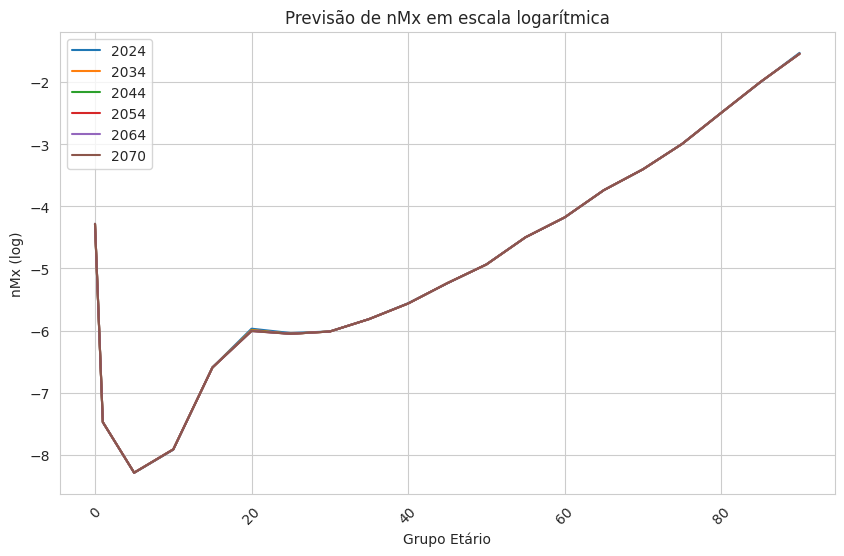

In [14]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2024], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2034], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2044], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2054], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2064], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_pred_male[df_pred_male['Ano'] == 2070], x='Grupo Etário', y=np.log(df_pred_male[df_pred_male['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [15]:
# Carregar métricas
df_metrics_male

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Masculino,0,0.000303,1.753797,0.000239
1,Brasil,Masculino,1,0.000013,1.907636,0.000011
2,Brasil,Masculino,5,0.000007,2.152523,0.000005
3,Brasil,Masculino,10,0.000026,5.966766,0.000022
4,Brasil,Masculino,15,0.000648,36.293064,0.000620
5,Brasil,Masculino,20,0.000228,7.965161,0.000216
6,Brasil,Masculino,25,0.000211,7.519080,0.000190
7,Brasil,Masculino,30,0.000214,6.906526,0.000178
8,Brasil,Masculino,35,0.000131,3.708866,0.000112
9,Brasil,Masculino,40,0.000169,3.788570,0.000145


In [16]:
# Carregar previsões para mulheres
df_pred_female = pd.read_csv('/content/previsoes_feminino_log.csv')
df_pred_female.head()


,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.011694,0.011694,0.011694
1,Brasil,Feminino,2021,0,0.011693,0.011693,0.011693
2,Brasil,Feminino,2022,0,0.011696,0.011696,0.011696
3,Brasil,Feminino,2023,0,0.011695,0.011695,0.011695
4,Brasil,Feminino,2024,0,0.011697,0.011697,0.011697


In [17]:
# Organizar por ano e grupo etário
df_pred_female = df_pred_female.sort_values(by=['Ano', 'Grupo Etário'])
df_pred_female.head()

,Local,Sexo,Ano,Grupo Etário,Previsão,Limite Inferior,Limite Superior
0,Brasil,Feminino,2020,0,0.011694,0.011694,0.011694
51,Brasil,Feminino,2020,1,0.000484,0.000484,0.000484
102,Brasil,Feminino,2020,5,0.000173,0.000173,0.000173
153,Brasil,Feminino,2020,10,0.000244,0.000244,0.000244
204,Brasil,Feminino,2020,15,0.000456,0.000456,0.000456


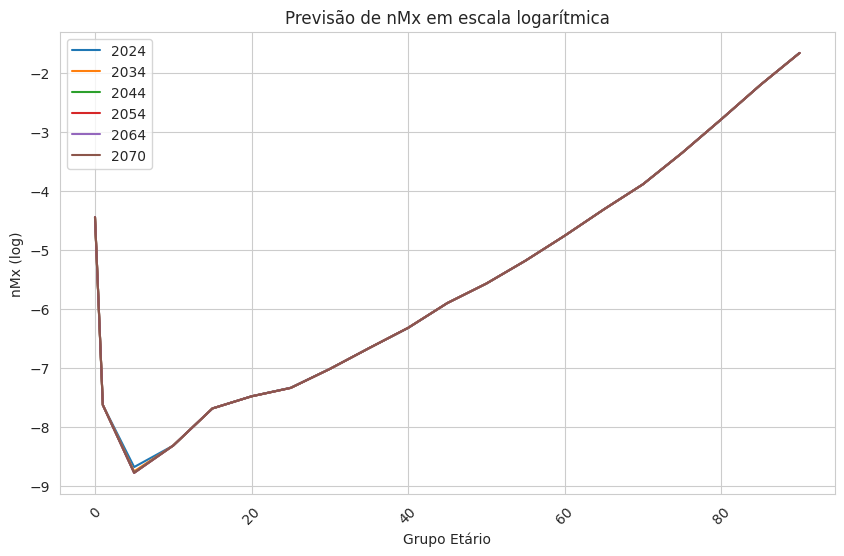

In [18]:
# Plotar Previsão de 2024, 2034, 2044, 2054, 2064, 2070
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2024], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2024]['Previsão']), label='2024')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2034], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2034]['Previsão']), label='2034')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2044], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2044]['Previsão']), label='2044')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2054], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2054]['Previsão']), label='2054')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2064], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2064]['Previsão']), label='2064')
sns.lineplot(data=df_pred_female[df_pred_female['Ano'] == 2070], x='Grupo Etário', y=np.log(df_pred_female[df_pred_female['Ano'] == 2070]['Previsão']), label='2070')
plt.xlabel('Grupo Etário')
plt.ylabel('nMx (log)')
plt.title('Previsão de nMx em escala logarítmica')
plt.legend()
plt.xticks(rotation=45) # Rotate y-axis labels by 45 degrees
plt.show()

In [19]:
# Carregar métricas
df_metrics_female

,Local,Sexo,Grupo Etário,RMSE,sMAPE,MAE
0,Brasil,Feminino,0,0.000330,2.345787,0.000270
1,Brasil,Feminino,1,0.000016,2.602196,0.000012
2,Brasil,Feminino,5,0.000024,12.556527,0.000024
3,Brasil,Feminino,10,0.000006,1.944616,0.000005
4,Brasil,Feminino,15,0.000013,2.553614,0.000012
5,Brasil,Feminino,20,0.000004,0.604484,0.000003
6,Brasil,Feminino,25,0.000020,2.218198,0.000015
7,Brasil,Feminino,30,0.000022,2.167954,0.000019
8,Brasil,Feminino,35,0.000038,2.630106,0.000033
9,Brasil,Feminino,40,0.000074,3.095526,0.000057
